## Logistic regression models for passenger gene HDs


In [9]:
import pandas as pd
import os
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.metrics import roc_curve, auc, roc_auc_score
import statsmodels.api as sm
from patsy import dmatrices
import random
from math import floor
import itertools
import re
import io
import sys
sys.path.append("../1_data_processing")
import warnings
warnings.simplefilter("ignore")

import graphing_params as gp
import processing_utils as util
import analysis_utils as au
%load_ext autoreload
%autoreload 1
%aimport graphing_params
%aimport processing_utils
%aimport analysis_utils

get_data_path = lambda folders, fname: os.path.normpath(os.environ['THIRD_PARTY_DIR']+'/'+'/'.join(folders) +'/'+fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)
get_fig_path = lambda fname: os.path.normpath('../figures/' + fname)

file_chrom_info = get_local_data_path(['processed'], 'hg19_chrom_info.csv')
file_fragsites = get_local_data_path(['processed'], 'hg19_fragile_sites.csv')
file_annot_genes = get_local_data_path(['processed'], 'HGNC_gene_annot_ens93_hg19.csv')
file_gene_HDs = get_local_data_path(['processed'], 'all_gene_HDs.csv')

# Output
file_table_s3 = get_local_data_path(['tables'], 'Table_S3_annotated_passenger_genes.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Annotate passenger genes w/ HD related features

In [3]:
chrom_info = pd.read_csv(file_chrom_info, index_col=0).reset_index()
chrom_info = chrom_info[~chrom_info.chr.isin(['X','Y'])].astype({'chr':int})

In [4]:
fragsites = pd.read_csv(file_fragsites)
print('N:', fragsites.shape[0])
fragsites['midpos'] = fragsites.startpos + ((fragsites.endpos-fragsites.startpos)*0.5)

N: 15


In [2]:
# Limit influence to 10Mb
def calc_dist_to_nearest_tsg(g, tsgs, maxd=10):
    chr_tsgs = tsgs[tsgs.chr==g.chr]
    if chr_tsgs.shape[0]==0: return 0 # No TSG on this chromosome
    chr_tsgs = chr_tsgs[['symbol','n_del']].assign(d = abs(g.cds_mid - chr_tsgs.cds_mid)/1000000)
    closest = chr_tsgs[chr_tsgs.d == chr_tsgs.d.min()].iloc[0]
    return max(maxd-closest.d, 0)

def calc_dist_to_fragsite(g, fragsites, maxd=10):
    sites = fragsites[fragsites.chr==g.chr]
    if sites.shape[0]==0: return 0 # No fragile sites on this chromosome
    sites = sites.assign(d = abs(g.cds_mid - sites.midpos)/1000000)
    closest = sites[sites.d == sites.d.min()].iloc[0]
    return max(maxd-closest.d, 0)

def calc_dist_to_centromere(g, maxd=10):
    info = chrom_info[chrom_info.chr==g.chr].iloc[0]
    if pd.isna(info.centStart):
        d = abs(info.centEnd - g.cds_mid)/1000000
    else:
        d = min(abs(info.centStart - g.cds_mid), abs(info.centEnd - g.cds_mid))/1000000
    return max(maxd-d, 0)

# From chroms 13,14,15,21,22 ONLY calculate distance from end
def calc_dist_to_telomere(g, maxd=10):
    chrom = chrom_info[chrom_info.chr==g.chr].iloc[0]
    if g.cds_mid > chrom.centEnd:
        d = (chrom['size'] - g.cds_mid)/1000000
    elif g.chr not in [13,14,15,22]:
        d = g.cds_mid/1000000
    else: return 0
    return max(maxd-d, 0)

In [5]:
gene_hds = pd.read_csv(file_gene_HDs)

In [6]:
recur_hd_tsgs = gene_hds[gene_hds.TSG & (gene_hds.n_del>=3)]
print('N 3+ HD TSGs:', recur_hd_tsgs.shape[0])

N 3+ HD TSGs: 90


In [7]:
passengers = gene_hds[~gene_hds.TSG & ~gene_hds.OG & ~gene_hds.within_driver & ~gene_hds.outside_bounds].reset_index(drop=True)
passengers = passengers[['symbol','entrez_id','ensembl_id','n_del','cds_from','cds_to','cds_mid','chr','cds_len',
                         'paralog','n_paralogs','WGD','max_seq_id']]
print('N:', passengers.shape[0])

N: 16898


In [8]:
data = passengers.assign(hd_tsg = passengers.apply(calc_dist_to_nearest_tsg, args=[recur_hd_tsgs], axis=1))
data = data.assign(fragsite = data.apply(calc_dist_to_fragsite, args=[fragsites], axis=1))
data = data.assign(centromere = data.apply(calc_dist_to_centromere, axis=1))
data = data.assign(telomere = data.apply(calc_dist_to_telomere, axis=1))

In [10]:
table_s3 = data[['symbol','entrez_id','ensembl_id','n_del','hd_tsg','fragsite','centromere','telomere','cds_len',
                     'paralog','n_paralogs','max_seq_id','WGD']]
table_s3['big_family'] = table_s3.n_paralogs.apply(lambda x: x>3 if not pd.isna(x) else x)
table_s3 = table_s3.rename(columns={'n_del':'n_HDs','hd_tsg':'dist_tsg','fragsite':'dist_fragsite',
                                    'centromere':'dist_centromere','telomere':'dist_telomere',
                                    'cds_len':'gene_length'}).drop(columns=['n_paralogs'])

In [11]:
table_s3[:3]

,symbol,entrez_id,ensembl_id,n_HDs,dist_tsg,dist_fragsite,dist_centromere,dist_telomere,gene_length,paralog,max_seq_id,WGD,big_family
0,CDKN2B,1030,ENSG00000147883,1276.0,9.975197,0.0,0.0,0.0,2966,True,78.9855,True,False
1,MTAP,4507,ENSG00000099810,874.0,9.849714,0.0,0.0,0.0,59265,False,NaN,NaN,NaN
2,DMRTA1,63951,ENSG00000176399,726.0,9.533178,0.0,0.0,0.0,4845,True,38.4921,False,False


In [12]:
table_s3.to_csv(file_table_s3, index=0)

### Normalize variables

In [14]:
variables = ['dist_tsg','dist_fragsite','dist_centromere','dist_telomere','gene_length']

def zscore_data(data):
    normdata = data.assign(
        del1 = (data.n_HDs>=1).astype(int),
        del3 = (data.n_HDs>=3).astype(int)
    )
    for col in variables:
        normdata[col] = stats.zscore(data[col])
    return normdata

In [15]:
normdata = zscore_data(table_s3)

In [17]:
normdata.dist_tsg.std()

1.0000295906138639

### Models for all passenger deletions

In [39]:
def convert_model_res(m):
    df =  pd.read_csv(io.StringIO(m.summary().tables[1].as_csv()), index_col=0)
    df.columns = [x.strip() for x in df.columns]
    df.index = [x.strip() for x in df.index]
    df = df.rename(columns={'[0.025':'lower','0.975]':'upper'})
    var_dict = {'paralog[T.True]':'Paralog', 
                'dist_tsg':'Distance to TSG', 
                'dist_fragsite':'Distance to fragile site', 
                'dist_centromere':'Distance to centromere', 
                'dist_telomere':'Distance to telomere',
                'gene_length':'Gene length',
                'big_family[T.True]':'Big family',
                'WGD[T.True]':'WGD', 
                'seqid':'Sequence Id.'}
    df['term'] = df.index
    df = df.replace(var_dict)
    df['cat'] = df.term.apply(lambda x: 'black' if x in ['Paralog','Big family','WGD','Sequence Id.'] else 
                              ('orange' if 'TSG' in x else 
                                ('sky-blue' if 'Distance to' in x else '#aaa')))
    df = df.reset_index(drop=True)
    return df

In [21]:
def draw_coefs_logit(mres, ax, n=1):
    sns.pointplot(np.exp(mres[1:].coef), mres[1:].term, join=False, scale=1.2, zorder=10, ax=ax,
                  palette=[gp.get_color(c) for c in mres[1:]['cat']]);
    for row in mres[1:].iterrows():
        clr = gp.get_color(row[1]['cat'])
        ax.hlines(y=row[0]-1, xmin=np.exp(row[1].lower), xmax=np.exp(row[1].upper), linewidth=2, color=clr, lw=1)
        ax.text(y=row[0]-1, x=np.exp(row[1].upper)+.02, 
                s='%.2f%s' % (np.exp(row[1].coef), ('**' if row[1]['P>|z|']<0.01 else ('*' if row[1]['P>|z|']<0.05 else ''))), 
                color=clr, va='center')
    gp.set_axis_props(ax, ytick_fontsize=9, xlabel='(Change in) Odds ratio', ylabel='', show_yticks=False)
    ax.set_title(str(n)+'+ HDs', fontweight='bold', fontsize=9)

#### 0 vs. 1+ / 0 vs. 3+ HDs

Optimization terminated successfully.
         Current function value: 0.634692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.353784
         Iterations 7
ROC AUC 1+: 0.64
ROC AUC 3+: 0.74


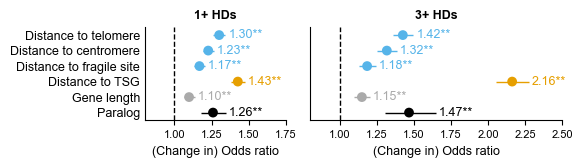

In [26]:
f, ax = plt.subplots(1, 2, figsize=(5.9, 1.75), sharey=True, gridspec_kw={'width_ratios':[0.56,1]})
m1 = smf.logit("del1 ~ paralog + gene_length + dist_tsg + dist_fragsite + dist_centromere + dist_telomere", data=normdata).fit()
draw_coefs_logit(convert_model_res(m1), ax[0], 1)
ax[0].set_xlim([0.8,1.75]); ax[0].set_ylim([-0.5,len(m1.params)-1.5]); ax[0].axvline(1, linestyle='--', color='k')

m3 = smf.logit("del3 ~ paralog + gene_length + dist_tsg + dist_fragsite + dist_centromere + dist_telomere", 
               data=normdata[(normdata.n_HDs==0) | (normdata.n_HDs>=3)]).fit()
draw_coefs_logit(convert_model_res(m3), ax[1], 3)
ax[1].set_xlim([0.8,2.5]); ax[1].set_ylim([-0.5,len(m1.params)-1.5]); ax[1].axvline(1, linestyle='--', color='k')

ypred=m1.predict()
print('ROC AUC 1+: %.2f' % (roc_auc_score(normdata.del1, ypred)))
ypred=m3.predict()
print('ROC AUC 3+: %.2f' % (roc_auc_score(normdata[(normdata.n_HDs==0) | (normdata.n_HDs>=3)].del3, ypred)))

plt.tight_layout()
plt.savefig('../figures/logit_model_all_dels.png', bbox_inches='tight', dpi=500, transparent=True)

In [27]:
#(1.75-0.8)/(2.5-0.8)

#### Likelihood ratio tests

In [28]:
def lr_test(m_full, m_rest):
    llf_full = m_full.llf
    llf_rest = m_rest.llf
    df_full = m_full.df_resid
    df_rest = m_rest.df_resid 
    lrdf = (df_rest - df_full)
    lrstat = -2*(llf_rest - llf_full)
    lr_pvalue = stats.chi2.sf(lrstat, df=lrdf)
    return lr_pvalue

In [29]:
m_full = smf.logit("del1 ~ paralog + gene_length + dist_tsg + dist_fragsite + dist_centromere + dist_telomere", 
                   data=normdata).fit()
m_rest = smf.logit("del1 ~ gene_length + dist_tsg + dist_fragsite + dist_centromere + dist_telomere", data=normdata).fit()
print(lr_test(m_full, m_rest))

Optimization terminated successfully.
         Current function value: 0.634692
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636052
         Iterations 5
1.2033936046810959e-11


In [30]:
m_full = smf.logit("del3 ~ paralog + gene_length + dist_tsg + dist_fragsite + dist_centromere + dist_telomere", 
                   data=normdata).fit()
m_rest = smf.logit("del3 ~ gene_length + dist_tsg + dist_fragsite + dist_centromere + dist_telomere", data=normdata).fit()
print(lr_test(m_full, m_rest))

Optimization terminated successfully.
         Current function value: 0.297256
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.298253
         Iterations 7
6.415764551096485e-09


### Models for paralog passenger deletions only

In [36]:
def norm_paralog_vars(data):
    normdata = data.assign(
        seqid = stats.zscore(data.max_seq_id)
    ).astype({'big_family':bool, 'WGD':bool})
    return normdata

In [38]:
pdata = normdata[normdata.paralog]
pdata = norm_paralog_vars(pdata)
pdata.shape[0]

10588

#### 0 vs. 1+ / 0 vs. 3+ HDs

Optimization terminated successfully.
         Current function value: 0.641486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.372658
         Iterations 6
ROC AUC 1+: 0.64
ROC AUC 3+: 0.75


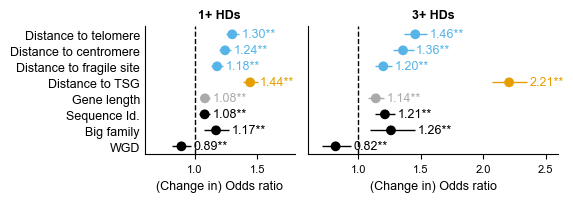

In [40]:
f, ax = plt.subplots(1, 2, figsize=(5.8, 2.1), sharey=True, gridspec_kw={'width_ratios':[0.6,1]})
m1 = smf.logit("del1 ~ WGD + big_family + seqid + gene_length + dist_tsg + dist_fragsite + dist_centromere + dist_telomere",
               data=pdata).fit()
draw_coefs_logit(convert_model_res(m1), ax[0], 1)
ax[0].set_xlim([0.6,1.8]); ax[0].set_ylim([-0.5,len(m1.params)-1.5]); ax[0].axvline(1, linestyle='--', color='k')

m3 = smf.logit("del3 ~ WGD + big_family + seqid + + gene_length + dist_tsg + dist_fragsite + dist_centromere + dist_telomere",
               data=pdata[(pdata.n_HDs==0) | (pdata.n_HDs>=3)]).fit()
draw_coefs_logit(convert_model_res(m3), ax[1], 3)
ax[1].set_xlim([0.6,2.6]); ax[1].set_ylim([-0.5,len(m3.params)-1.5]); ax[1].axvline(1, linestyle='--', color='k')

ypred=m1.predict()
print('ROC AUC 1+: %.2f' % (roc_auc_score(pdata.del1, ypred)))
ypred=m3.predict()
print('ROC AUC 3+: %.2f' % (roc_auc_score(pdata[(pdata.n_HDs==0) | (pdata.n_HDs>=3)].del3, ypred)))

plt.tight_layout()
plt.savefig('../figures/logit_model_paralog_dels.png', bbox_inches='tight', dpi=500, transparent=True)

In [41]:
#(1.8-0.6)/(2.6-0.6)

#### Likelihood ratio tests

In [43]:
m_full = smf.logit("del1 ~ WGD + big_family + seqid + "
                   "gene_length + dist_tsg + dist_fragsite + dist_centromere + dist_telomere", data=pdata).fit()

m_rest = smf.logit("del1 ~ big_family + seqid + "
                   "gene_length + dist_tsg + dist_fragsite + dist_centromere + dist_telomere", data=pdata).fit()
print('W/out WGD:', lr_test(m_full, m_rest))

m_rest = smf.logit("del1 ~ WGD + seqid + "
                   "gene_length + dist_tsg + dist_fragsite + dist_centromere + dist_telomere", data=pdata).fit()
print('W/out big_family:', lr_test(m_full, m_rest))

m_rest = smf.logit("del1 ~ WGD + big_family + "
                   "gene_length + dist_tsg + dist_fragsite + dist_centromere + dist_telomere", data=pdata).fit()
print('W/out seqid:', lr_test(m_full, m_rest))

Optimization terminated successfully.
         Current function value: 0.641486
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.641815
         Iterations 5
W/out WGD: 0.008394368746150968
Optimization terminated successfully.
         Current function value: 0.642096
         Iterations 5
W/out big_family: 0.00032758757168380837
Optimization terminated successfully.
         Current function value: 0.642087
         Iterations 5
W/out seqid: 0.0003620054611644381
